In [1]:
## residual images for different noise level

In [3]:
import os
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(256, 256)
(256, 256)


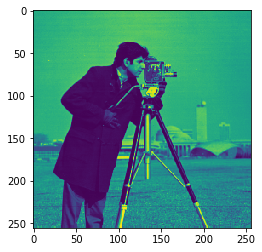

In [14]:
test_image_path = "./data/Test/Set12/"
image_name = "01.png"
x = np.asarray(imread(os.path.join(test_image_path,image_name)),dtype=np.float32)/ 255.0
plt.imshow(x)
print(x.shape)

np.random.seed(seed=0) # for reproducibility
y = x + np.random.normal(0, 0/255.0, x.shape) # Add Gaussian noise without clipping
y = y.astype(np.float32)
plt.imshow(y)
print(y.shape)

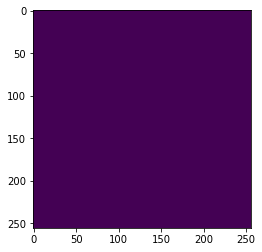

In [15]:
plt.imshow(y-x)

In [16]:
## diverged network

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,Dense,Reshape
from keras.models import Model, load_model

Using TensorFlow backend.


In [19]:
import sys
sys.path.append("./Func")
from loading_data import DataLoader_base
from building_network import NetworkBuild_base
from run_network import NetworkRun_base
from editing_network import NetworkEdit_base

In [18]:
def MyDnCNN(depth,filters=64,image_shape=(256,256,1), # Height, Width, Channel
            use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=image_shape,name = 'input'+str(layer_count))
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            #x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x) 
        x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)  
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=image_shape[-1], kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
#     print(image_shape)
    
    return model

In [20]:
test_net = NetworkEdit_base(model=MyDnCNN(17))
load_path = "./models/DnCNN_sigma25/model.h5"
test_net.LoadModel("WEIGHTS",load_path)
print(test_net.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, 256, 256, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 256, 256, 64) 36864       relu2[0][0]                      
__________________________________________________________________________________________________
bn4 (Batch

(1, 256, 256, 1)
23.288727351 0.818152540584


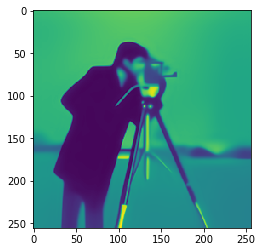

In [35]:
y = np.reshape(x_predict,(1,256,256,1))
x_predict = test_net.model.predict(y)
print(x_predict.shape)
x_predict = np.reshape(x_predict,(256,256))
plt.imshow(x_predict)
psnr_x_ = compare_psnr(x, x_predict)
ssim_x_ = compare_ssim(x, x_predict)
print(psnr_x_,ssim_x_)

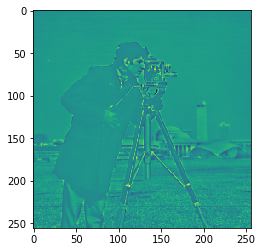

In [36]:
plt.imshow(x-x_predict)